In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('../model_data/quality_nj2.csv')
encoder1, encoder2, encoder3, encoder4 = LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder()
df['RATING_EVENT_CODE'] = encoder1.fit_transform(df['RATING_EVENT'])
df['ENTRY_NAME_CODE'] = encoder2.fit_transform(df['ENTRY_NAME'])
df['PLT_ID_CODE'] = encoder3.fit_transform(df['PLT_ID'])
df['RATER_CODE'] = encoder4.fit_transform(df['RATER'])
plt_coords = df.groupby('PLT_ID_CODE')[['ROW','COL']].mean()
year = pd.to_datetime(df['DATE']).dt.year
num_days_in_year = pd.to_datetime(year.astype(str), format='%Y').dt.is_leap_year * 366 + (~pd.to_datetime(year.astype(str), format='%Y').dt.is_leap_year) * 365
df['DAY_OF_YEAR'] = pd.to_datetime(df['DATE']).dt.dayofyear
df['TIME_OF_YEAR'] = df['DAY_OF_YEAR']/num_days_in_year
df['ENTRY_CUMCOUNT'] = df.groupby('ENTRY_NAME').cumcount() + 1
df.head()

/tmp/ipykernel_18141/2479036520.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  year = pd.to_datetime(df['DATE']).dt.year
/tmp/ipykernel_18141/2479036520.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DAY_OF_YEAR'] = pd.to_datetime(df['DATE']).dt.dayofyear


,PLT_ID,TRAIT,DATE,QUALITY,ENTRY_CODE,ENTRY_NAME,COMP,RATER,ROW,COL,...,RATING_EVENT_CODE,MONTH_CODE,YEAR_CODE,TEST_LOC,ENTRY_NAME_CODE,PLT_ID_CODE,RATER_CODE,DAY_OF_YEAR,TIME_OF_YEAR,ENTRY_CUMCOUNT
0,241,Turf Quality,4/18/18,4,37,NAI-14-132,Columbia River Seed,RMD,17,1,...,7,1,1,"Adelphia, NJ",62,238,3,108,0.295890,1
1,241,Turf Quality,5/10/18,4,37,NAI-14-132,Columbia River Seed,RON,17,1,...,12,6,1,"Adelphia, NJ",62,238,4,130,0.356164,2
2,241,Turf Quality,6/7/18,5,37,NAI-14-132,Columbia River Seed,RON,17,1,...,13,4,1,"Adelphia, NJ",62,238,4,158,0.432877,3
3,241,Turf Quality,7/17/18,5,37,NAI-14-132,Columbia River Seed,RON,17,1,...,14,3,1,"Adelphia, NJ",62,238,4,198,0.542466,4
4,241,Turf Quality,8/15/18,6,37,NAI-14-132,Columbia River Seed,RMD,17,1,...,8,2,1,"Adelphia, NJ",62,238,3,227,0.621918,5


In [4]:
padding = 5       # Padding for Fourier GP plot effect
num_rows = 18     # Number of rows of the turfgrass plot
num_cols = 15     # Number of columns of the turfgrass plot
pred_N = 100      # Split 1 year into pred_N points, and make a prediction of time effect for each point
num_basis_functions = 6 # Number of basis functions for time effect

stan_data_time = {"N": len(df["QUALITY"]),                 # Number of responses
             "num_raters":len(df['RATER'].unique()),         # Total number of rating events
             "num_entries":len(df['ENTRY_NAME'].unique()),           # Total number of entries (turfgrass types)
             "num_plots":len(df['PLT_ID'].unique()),               # Total number of plots 
             "num_categories": 9,                                       # Total number of rating categories
             "num_events_by_rater": df.groupby('RATER_CODE')['PLT_ID'].count(),
             "rater_id": df["RATER_CODE"].values+1,       # rating id for y[n], defined by rater + date
             "entry_id": df["ENTRY_NAME_CODE"].values+1,         # entry of y[n]
             "plot_id": df["PLT_ID_CODE"].values+1,             # plot id of y[n]
             "y": df["QUALITY"].values,                    # the rating value of y[n] that we are trying to model
            
             # values used for fourier scalable gaussian process inference, plot effect
             "num_rows": num_rows,
             "num_cols": num_cols,
             "num_rows_padded": num_rows + padding,
             "num_cols_padded": num_cols + padding,
             "plot_row" : plt_coords["ROW"].astype(int),
             "plot_col" : plt_coords["COL"].astype(int),
                  
             # values used for time GP
             "time" : df['TIME_OF_YEAR']+df['YEAR'],
             "c_f" : 1.5,
             "M_f":num_basis_functions, # number of Hilbert Basis functions
             "num_ratings_per_entry": np.max(df.groupby('ENTRY_NAME').count()['PLT_ID']),
             "entry_cumcount": df["ENTRY_CUMCOUNT"],
             
             # values for making predictions
             "pred_N": pred_N,
             "pred_time": np.linspace(0,1,pred_N+1)[1:]
              }

In [1]:
import pickle
with open("jan-14-2024-modelv8-sharedparams.pkl", "rb") as f:
    fit = pickle.load(f)['fit']

/root/.cache/pypoetry/virtualenvs/stan-env-Zdpe4cqc-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import arviz as az
az_data = az.from_cmdstanpy(
    posterior=fit,
    observed_data={"y": stan_data_time['y']},
    log_likelihood="log_lik",
)
az_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

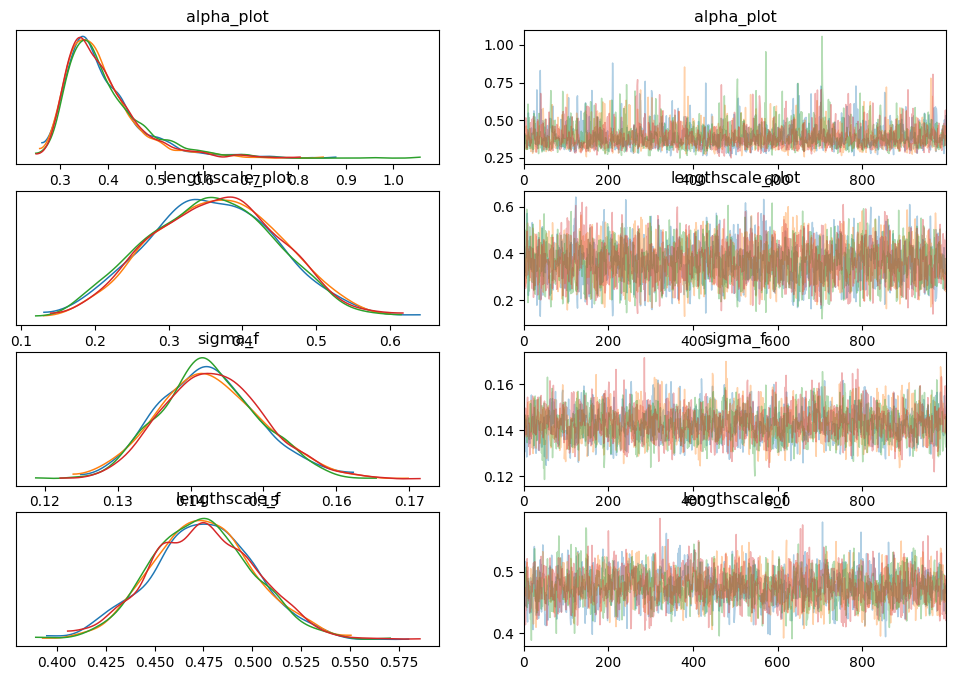

In [30]:
# analyze convergence of the chains

az.plot_trace(az_data, compact=False, var_names=['alpha_plot','lengthscale_plot','sigma_f','lengthscale_f']);

In [7]:
data_loo = az.loo(az_data)
data_loo

Computed from 4000 posterior samples and 9612 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -15125.15    72.02
p_loo      725.00        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9609  100.0%
 (0.5, 0.7]   (ok)          3    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

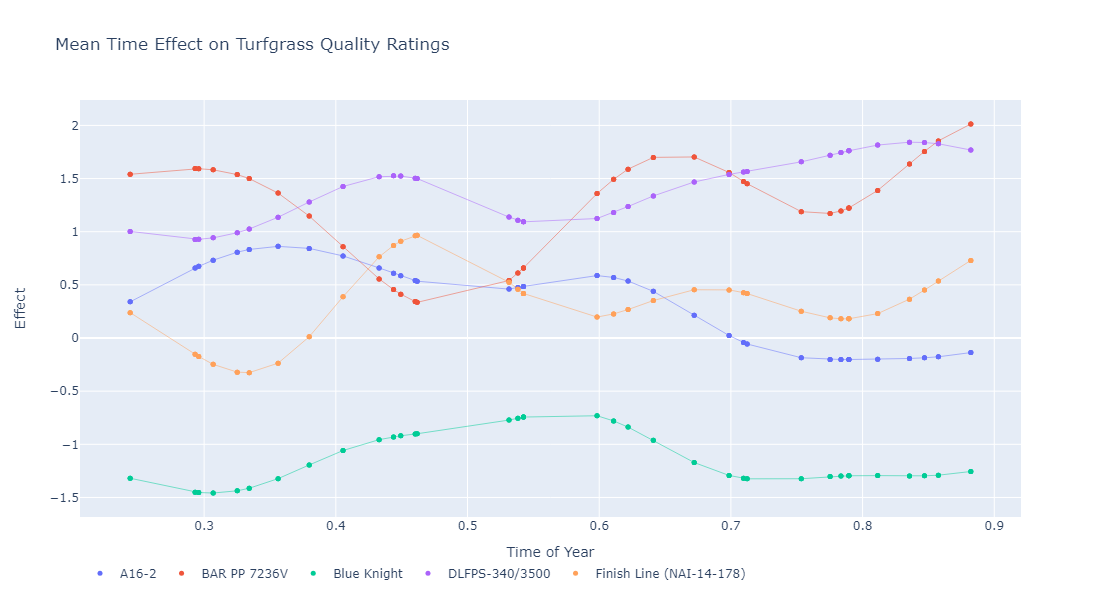

In [14]:
import plotly.graph_objects as go
import plotly.io as pio
import random

### SELECT WHICH ENTRIES TO PLOT

entries = [10,20,30,40,50]
random_entries = False

###

colors = pio.templates["plotly"].layout.colorway

if random_entries:
    entries = [i for i in range(stan_data_time["num_entries"])]
    random.shuffle(rand_entries)
    entries = entries[:len(colors)]

fig = go.Figure()

for idx, i in enumerate(entries):
    x = list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])
    sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
    x_sorted = [list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])[ind] for ind in sorted_indices]
    y_sorted = [fit.time_effect[:,i].mean(axis=0)[ind] for ind in sorted_indices]    
    entry_name = list(df[df["ENTRY_NAME_CODE"] == i]['ENTRY_NAME'])[0]
    fig.add_trace(go.Scatter(x=x_sorted, y=y_sorted, mode='markers', marker=dict(size=5, color=colors[idx]),
                             name=entry_name, legendgroup=entry_name))
    fig.add_trace(go.Scatter(x=x_sorted, y=y_sorted, mode='lines', line=dict(width=0.5, color=colors[idx]),
                             name=entry_name, showlegend=False, legendgroup=entry_name))
fig.update_layout(title='Mean Time Effect on Turfgrass Quality Ratings',
                  xaxis_title='Time of Year',
                  yaxis_title='Effect',
                  width=1000,  # Set the width of the figure in pixels
                  height=600,  # Set the height of the figure in pixels
                  legend=dict(orientation="h", tracegroupgap=10))
fig.show()

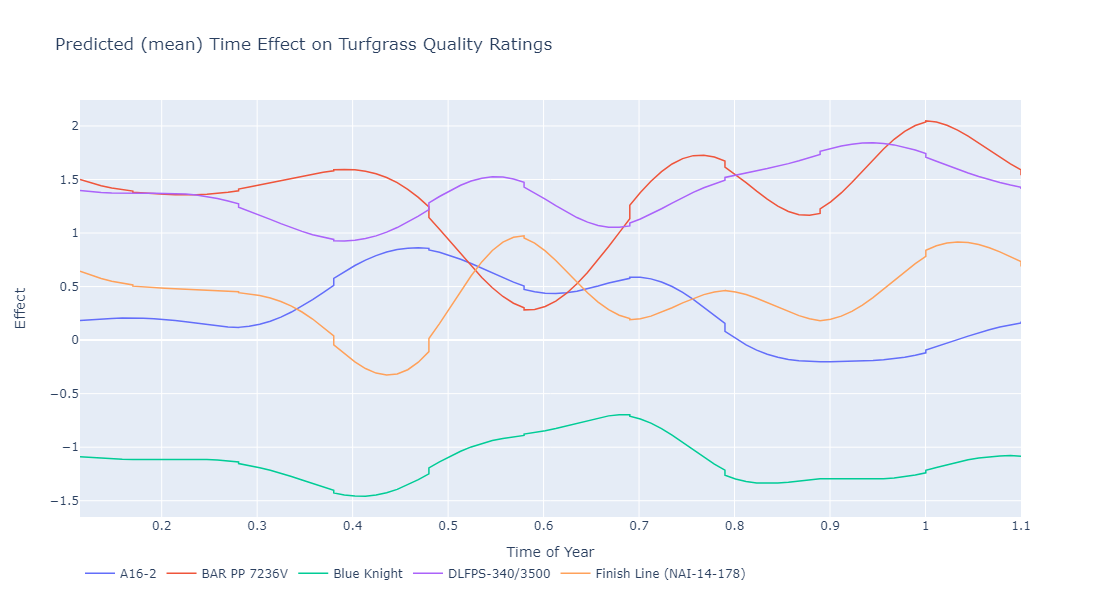

In [27]:
### SELECT WHICH ENTRIES TO PLOT

entries = [10,20,30,40,50]
random_entries = False

###

colors = pio.templates["plotly"].layout.colorway
mean_x = np.mean(df['TIME_OF_YEAR']+df['YEAR'])
std_x = np.std(df['TIME_OF_YEAR']+df['YEAR'])

if random_entries:
    entries = [i for i in range(stan_data_time["num_entries"])]
    random.shuffle(rand_entries)
    entries = entries[:len(colors)]

fig = go.Figure()

for idx, i in enumerate(entries):
    x = list(fit.pred_xn.mean(axis=0)*std_x+mean_x)
    y = fit.pred_time_effect[:,i].mean(axis=0)   
    entry_name = list(df[df["ENTRY_NAME_CODE"] == i]['ENTRY_NAME'])[0]
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(width=1.5, color=colors[idx]),
                             name=entry_name, legendgroup=entry_name))
fig.update_layout(title='Predicted (mean) Time Effect on Turfgrass Quality Ratings',
                  xaxis_title='Time of Year',
                  yaxis_title='Effect',
                  width=1000,  # Set the width of the figure in pixels
                  height=600,  # Set the height of the figure in pixels
                  legend=dict(orientation="h", tracegroupgap=10))
fig.show()

<Axes: >

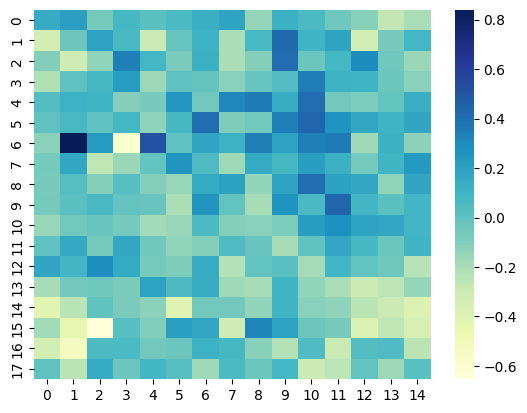

In [31]:
PLT_ROW = df.groupby('PLT_ID')[['ROW', 'COL']].max()['ROW']
PLT_COL = df.groupby('PLT_ID')[['ROW', 'COL']].max()['COL']
mean_matrix_time = np.zeros((np.max(PLT_ROW)+1, np.max(PLT_COL)+1))
mean_matrix_time[PLT_ROW, PLT_COL] = fit.plot_effect.mean(axis=0)
sns.heatmap(mean_matrix_time[1:,1:], cmap="YlGnBu")

Text(0.5, 1.0, 'Mean Time Effect Recorded for Each Entry')

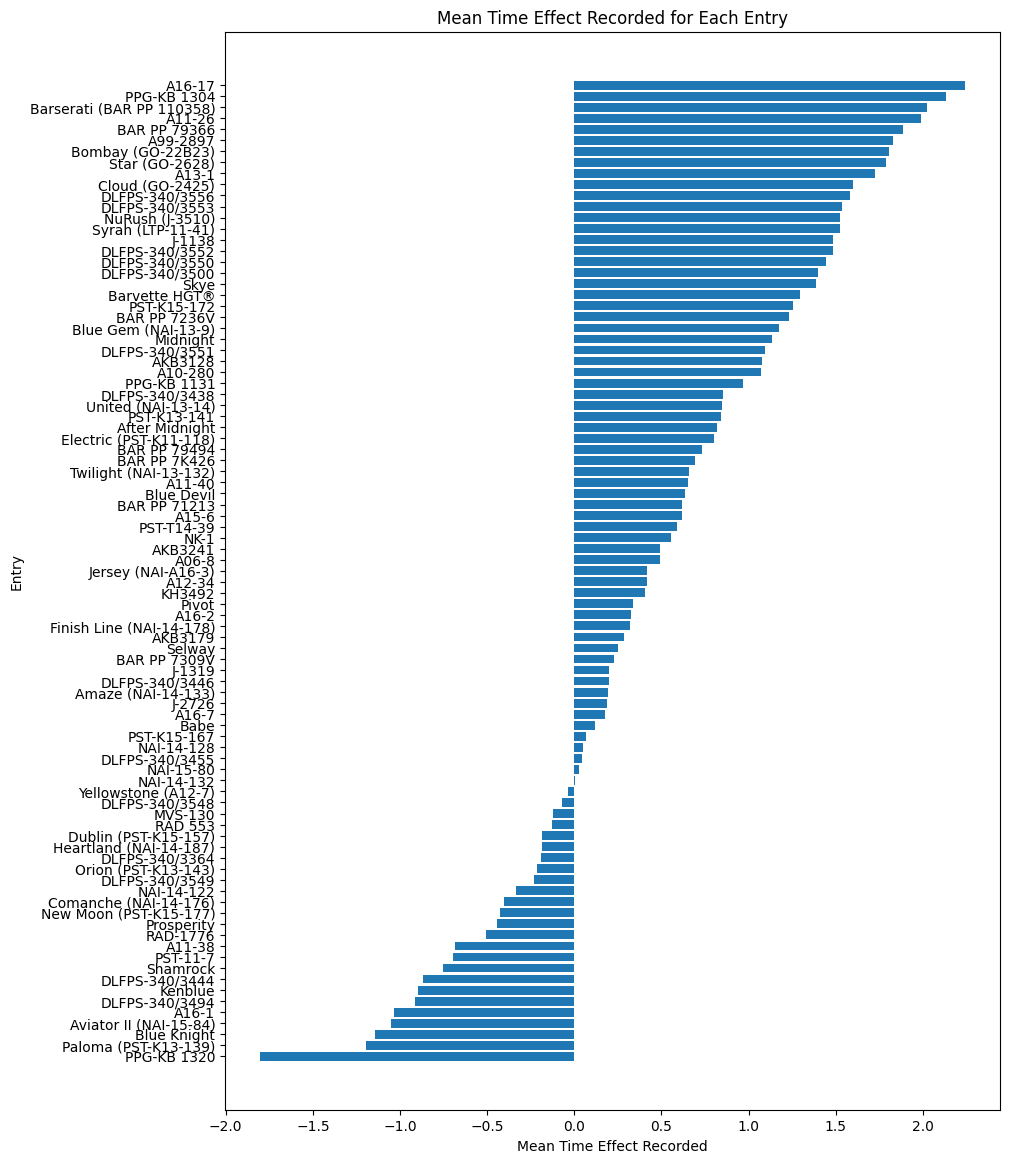

In [32]:
fig, ax = plt.subplots(figsize=(10, 14))
e_codes = df.groupby('ENTRY_NAME')['ENTRY_NAME_CODE'].mean()
entry_dict = {}
for j in e_codes.index:
    entry_dict[round(e_codes[j])] = j
intercept_f = list(fit.time_effect.mean(axis=0).mean(axis=1))

# Generate x-axis values and corresponding entry names
y = range(len(intercept_f))
entry_names = [entry_dict[i] for i in y]
entry_names_sorted = sorted(entry_names, key = lambda x : intercept_f[entry_names.index(x)])
intercept_f_sorted = sorted(intercept_f)
bar = ax.barh(y, intercept_f_sorted)

# Set the x-axis tick labels to the entry names
ax.set_yticks(y, entry_names_sorted)

# Add labels and title
ax.set_ylabel('Entry')
ax.set_xlabel('Mean Time Effect Recorded')
ax.set_title('Mean Time Effect Recorded for Each Entry')

Text(0.5, 1.0, 'Mean Predicted Time Effect for Each Entry')

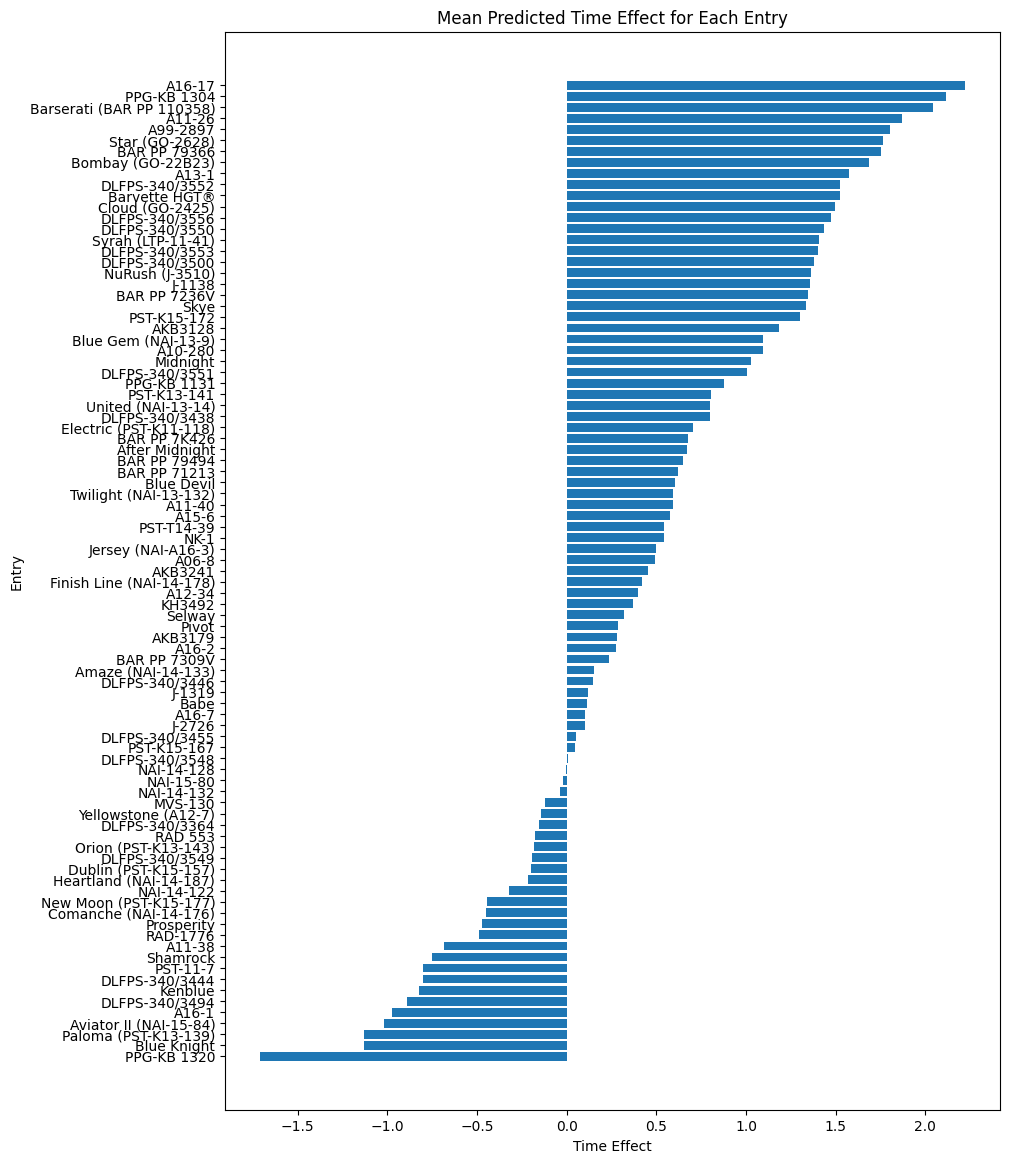

In [35]:
fig, ax = plt.subplots(figsize=(10, 14))
e_codes = df.groupby('ENTRY_NAME')['ENTRY_NAME_CODE'].mean()
entry_dict = {}
for j in e_codes.index:
    entry_dict[round(e_codes[j])] = j
intercept_f = list(fit.pred_time_effect.mean(axis=0).mean(axis=1))

# Generate x-axis values and corresponding entry names
y = range(len(intercept_f))
entry_names = [entry_dict[i] for i in y]
entry_names_sorted = sorted(entry_names, key = lambda x : intercept_f[entry_names.index(x)])
intercept_f_sorted = sorted(intercept_f)
bar = ax.barh(y, intercept_f_sorted)

# Set the x-axis tick labels to the entry names
ax.set_yticks(y, entry_names_sorted)

# Add labels and title
ax.set_ylabel('Entry')
ax.set_xlabel('Time Effect')
ax.set_title('Mean Predicted Time Effect for Each Entry')